Epoch 1/50
88/88 [==============================] - 15s 74ms/step - loss: 0.1516 - rmse_loss: 0.1512 - val_loss: 0.1137 - val_rmse_loss: 0.1137
Epoch 2/50
88/88 [==============================] - 5s 54ms/step - loss: 0.0698 - rmse_loss: 0.0698 - val_loss: 0.0845 - val_rmse_loss: 0.0845
Epoch 3/50
88/88 [==============================] - 5s 54ms/step - loss: 0.0632 - rmse_loss: 0.0631 - val_loss: 0.0767 - val_rmse_loss: 0.0767
Epoch 4/50
88/88 [==============================] - 5s 54ms/step - loss: 0.0605 - rmse_loss: 0.0605 - val_loss: 0.0716 - val_rmse_loss: 0.0716
Epoch 5/50
88/88 [==============================] - 5s 54ms/step - loss: 0.0600 - rmse_loss: 0.0600 - val_loss: 0.0718 - val_rmse_loss: 0.0718
Epoch 6/50
88/88 [==============================] - 5s 53ms/step - loss: 0.0585 - rmse_loss: 0.0585 - val_loss: 0.0598 - val_rmse_loss: 0.0598
Epoch 7/50
88/88 [==============================] - 5s 54ms/step - loss: 0.0572 - rmse_loss: 0.0573 - val_loss: 0.0584 - val_rmse_loss: 0.058

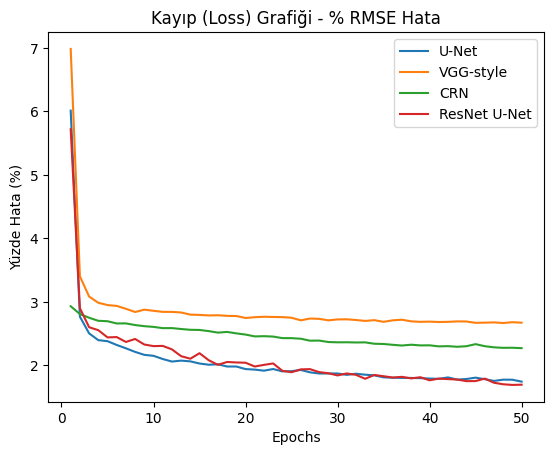

In [1]:
import os
import numpy as np
import tensorflow as tf
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from scipy.signal import stft
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split

# Dosya yolları
train_dir = r'C:\Users\emret\Desktop\Yeni Klasör\train\train'
y_train_dir = r'C:\Users\emret\Desktop\Yeni Klasör\train\y_train'
test_dir = r'C:\Users\emret\Desktop\Yeni Klasör\test\test'
y_test_dir = r'C:\Users\emret\Desktop\Yeni Klasör\test\y_test'

# Ses dosyasını yükle ve spectrograma dönüştür
def load_and_process_audio(file_path, sr=16000, target_length=None):
    orig_sr, y = wav.read(file_path)
    if y.ndim > 1:
        y = y[:, 0]
    y = y.astype(np.float32)
    if orig_sr != sr:
        raise ValueError(f"Dosya {file_path} beklenen örnekleme oranına ({sr}) sahip değil. Mevcut: {orig_sr}")
    if target_length is None:
        target_length = sr * 15
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)), mode='constant')
    else:
        y = y[:target_length]
    y = (y - np.mean(y)) / np.std(y)

    f, t, Zxx = stft(y, fs=sr, nperseg=512, noverlap=256)
    Sxx = np.abs(Zxx)
    log_spec = np.log1p(Sxx)
    log_spec = np.resize(log_spec, (64, 64))
    log_spec = log_spec[..., np.newaxis]
    return log_spec, y

# Dataset yükleme
def load_dataset(dir_path, target_length=None):
    files = os.listdir(dir_path)
    mel_specs = []
    audio_data = []
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(dir_path, file)
            mel_spec, audio = load_and_process_audio(file_path, target_length=target_length)
            mel_specs.append(mel_spec)
            audio_data.append(audio)
    return np.array(mel_specs), np.array(audio_data)

X_all, X_all_audio = load_dataset(train_dir)
Y_all, Y_all_audio = load_dataset(y_train_dir)

X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)
X_train_audio, X_test_audio = train_test_split(X_all_audio, test_size=0.2, random_state=42)
Y_train_audio, Y_test_audio = train_test_split(Y_all_audio, test_size=0.2, random_state=42)

def rmse_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Model 1: UNet
def unet_model(input_size=(64, 64, 1)):
    inputs = layers.Input(input_size)
    c1 = layers.Conv2D(16, (3, 3), activation=tf.nn.leaky_relu, padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(16, (3, 3), activation=tf.nn.leaky_relu, padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.6)(p1)
    c2 = layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.6)(p2)
    c3 = layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    u4 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding='same')(u4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    u5 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(16, (3, 3), activation=tf.nn.leaky_relu, padding='same')(u5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(16, (3, 3), activation=tf.nn.leaky_relu, padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    outputs = layers.Conv2D(1, (1, 1), activation=tf.nn.leaky_relu)(c5)
    model = models.Model(inputs, outputs)
    return model

def vgg_style_denoiser(input_shape=(64, 64, 1)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.leaky_relu)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.leaky_relu)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.leaky_relu)(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.leaky_relu)(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2,2))(x)
    outputs = layers.Conv2D(1, (1,1), padding='same', activation=tf.nn.leaky_relu)(x)
    model = models.Model(inputs, outputs)
    return model

def cnn_lstm_denoiser(input_shape=(64, 64, 1)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Reshape((32, 32*64))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.TimeDistributed(layers.Dense(32*64))(x)
    x = layers.Reshape((32, 32, 64))(x)
    outputs = layers.Conv2D(1, (1,1), padding='same', activation=tf.nn.leaky_relu)(x)
    outputs = layers.UpSampling2D((2, 2))(outputs)
    model = models.Model(inputs, outputs)
    return model

def resnet_unet(input_shape=(64, 64, 1)):
    inputs = layers.Input(shape=input_shape)
    def residual_block(x, filters):
        shortcut = x
        x = layers.Conv2D(filters, (3,3), padding='same', activation=tf.nn.leaky_relu)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3,3), padding='same', activation=tf.nn.leaky_relu)(x)
        x = layers.BatchNormalization()(x)
        return layers.add([shortcut, x])
    c1 = layers.Conv2D(32, (3,3), activation=tf.nn.leaky_relu, padding='same')(inputs)
    c1 = residual_block(c1, 32)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.6)(p1)
    c2 = layers.Conv2D(64, (3,3), activation=tf.nn.leaky_relu, padding='same')(p1)
    c2 = residual_block(c2, 64)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.6)(p2)
    c3 = layers.Conv2D(128, (3,3), activation=tf.nn.leaky_relu, padding='same')(p2)
    c3 = residual_block(c3, 128)
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(64, (3,3), activation=tf.nn.leaky_relu, padding='same')(u1)
    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(32, (3,3), activation=tf.nn.leaky_relu, padding='same')(u2)
    outputs = layers.Conv2D(1, (1,1), activation=tf.nn.leaky_relu)(c5)
    model = models.Model(inputs, outputs)
    return model

models_to_train = [unet_model(), vgg_style_denoiser(), cnn_lstm_denoiser(), resnet_unet()]
losses = []
model_names = ['U-Net', 'VGG-style', 'CRN', 'ResNet U-Net']
y_range = np.max(Y_train) - np.min(Y_train)

for i, model in enumerate(models_to_train):
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss=rmse_loss, metrics=[rmse_loss])
    history = model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_test, Y_test))
    loss_values = [(loss / y_range) * 100 for loss in history.history['loss']]
    losses.append(loss_values)
    plt.plot(range(1, len(loss_values) + 1), loss_values, label=model_names[i])

plt.title('Kayıp (Loss) Grafiği - % RMSE Hata')
plt.xlabel('Epochs')
plt.ylabel('Yüzde Hata (%)')
plt.legend()
plt.show()

4/4 [==============================] - 0s 95ms/step


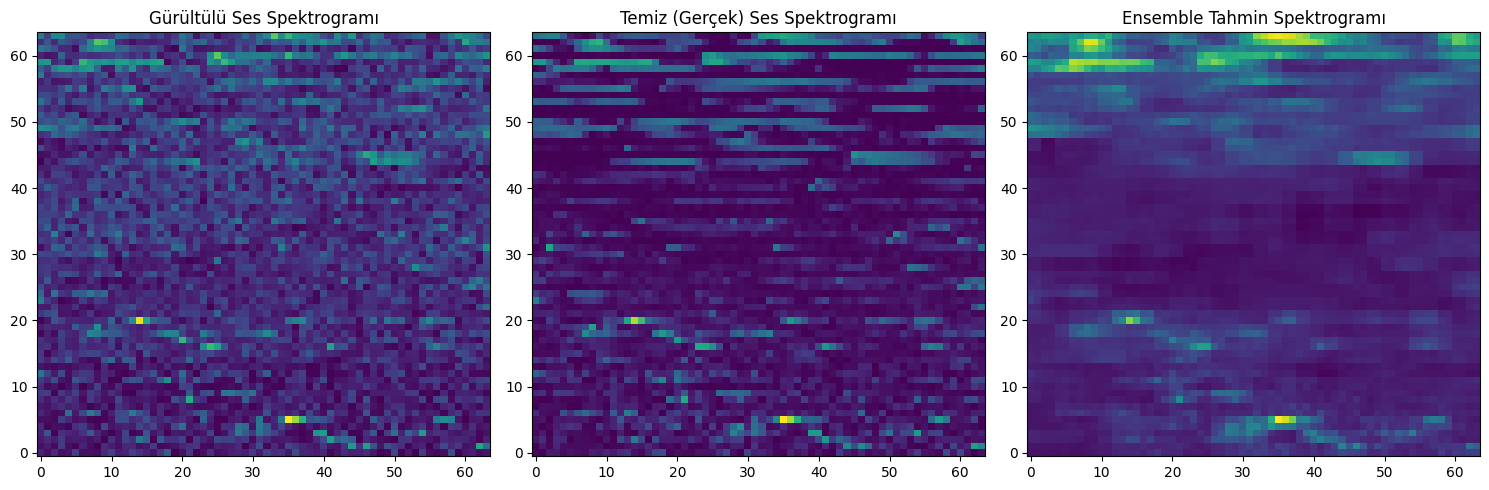

🎧 Tahmin sesleri başarıyla kaydedildi:
- Gürültülü: ./tahmin_sonuclari/gürültülü.wav
- Temiz (gerçek): ./tahmin_sonuclari/temiz_gercek.wav
- Model Tahmini: ./tahmin_sonuclari/tahmin_edilmis.wav


In [2]:
from scipy.io.wavfile import write as write_wav

# Test verisini yükle
X_test_spectrograms, X_test_audios = load_dataset(test_dir)
Y_test_spectrograms, Y_test_audios = load_dataset(y_test_dir)

# Modellerin çıktılarının normalize edilip ensemble edilmesi
predictions = []
for model in models_to_train:
    pred = model.predict(X_test_spectrograms)
    # Normalize et
    pred = (pred - np.min(pred)) / (np.max(pred) - np.min(pred))
    predictions.append(pred)

# Ensemble: Ortalama alma
ensemble_pred = np.mean(np.array(predictions), axis=0)

# Görsel kontrol için örnek index
idx = 0
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(X_test_spectrograms[idx].squeeze(), origin='lower', aspect='auto', cmap='viridis')
axs[0].set_title("Gürültülü Ses Spektrogramı")

axs[1].imshow(Y_test_spectrograms[idx].squeeze(), origin='lower', aspect='auto', cmap='viridis')
axs[1].set_title("Temiz (Gerçek) Ses Spektrogramı")

axs[2].imshow(ensemble_pred[idx].squeeze(), origin='lower', aspect='auto', cmap='viridis')
axs[2].set_title("Ensemble Tahmin Spektrogramı")

plt.tight_layout()
plt.show()

# Spektrogramdan geri dalga formuna geçiş (sadece örnek için sadeleştirilmiş ters işlem)
# Not: Bu işlem birebir eski sesleri vermez. STFT tersine çevrilemediği için tahmini bir şekilde yapılır.

def dummy_inverse_spectrogram(spectrogram, length=16000*15):
    # Spektrogramı basitleştirilmiş şekilde dalga formuna dönüştür
    # Gerçek bir inverse STFT yerine sadeleştirilmiş bir tahmindir
    spectrogram = np.squeeze(spectrogram)
    spectrogram = np.exp(spectrogram) - 1  # Ters log1p
    flat_audio = spectrogram.mean(axis=0)
    flat_audio = np.interp(np.linspace(0, len(flat_audio), length), np.arange(len(flat_audio)), flat_audio)
    return flat_audio.astype(np.float32)

# Gürültülü, temiz ve tahmini sesleri kurtar
noisy_audio = X_test_audios[idx]
clean_audio = Y_test_audios[idx]
denoised_audio = dummy_inverse_spectrogram(ensemble_pred[idx])

# WAV dosyası olarak kaydet
output_dir = "./tahmin_sonuclari"
os.makedirs(output_dir, exist_ok=True)

write_wav(os.path.join(output_dir, "gürültülü.wav"), 16000, noisy_audio)
write_wav(os.path.join(output_dir, "temiz_gercek.wav"), 16000, clean_audio)
write_wav(os.path.join(output_dir, "tahmin_edilmis.wav"), 16000, denoised_audio)

print("🎧 Tahmin sesleri başarıyla kaydedildi:")
print(f"- Gürültülü: {output_dir}/gürültülü.wav")
print(f"- Temiz (gerçek): {output_dir}/temiz_gercek.wav")
print(f"- Model Tahmini: {output_dir}/tahmin_edilmis.wav")